In [1]:
#데이터 처리
import pandas as pd
#행렬 연산
import numpy as np
#데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#회기 분석
from statsmodels.formula.api import ols
#qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형 모델 formula(y~ X1 +X2 + ...)
import statsmodels.formula.api as smf
#다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
#학습용/평가용 데이터 분리:train, test
from sklearn.model_selection import train_test_split
#선형회귀모형
from sklearn.linear_model import LinearRegression
#변수 선택법(후진제거법)
from sklearn.feature_selection import RFE
#Scale 변환 ->표준화 회구계수 산출
from sklearn.preprocessing import StandardScaler
#평가함수
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

#폰트 적용 시 & 음수 표시
import matplotlib.font_manager as fm
%matplotlib inline

path =  '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc'
fontprop = fm.FontProperties(fname=path, size=18).get_name()
matplotlib.rc('font',family=fontprop)
matplotlib.rc('axes', unicode_minus = False)


import warnings
warnings.filterwarnings('ignore')

In [2]:
df_raw=pd.read_csv("/home/piai/바탕화면/2. Big Data 분석/체질검사.csv")
df_raw.head()

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  ANKLE  \
0  35.2   46  363.15   72.25  51.2  136.2    148.1  147.7   87.3  49.1   29.6   
1  11.8   27  168.00   71.25  38.1   93.0     79.1   94.5   57.3  36.2   24.5   
2  22.2   69  177.75   68.50  38.7  102.0     95.0   98.3   55.0  38.3   21.8   
3  10.6   57  147.75   65.75  35.2   99.6     86.4   90.1   53.0  35.0   21.3   
4  47.5   51  219.00   64.00  41.2  119.8    122.1  112.8   62.5  36.9   23.6   

   BICEPS  FOREARM  WRIST  
0    45.0     29.0   21.4  
1    29.0     30.0   18.8  
2    30.8     25.7   18.8  
3    31.7     27.3   16.9  
4    34.7     29.1   18.4

- BMI 열 추가 

In [3]:
df_raw['BMI'] = (df_raw['WEIGHT']*0.45)/((df_raw['HEIGHT']*0.0254)**2)
df_raw.head()

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN    HIP  THIGH  KNEE  ANKLE  \
0  35.2   46  363.15   72.25  51.2  136.2    148.1  147.7   87.3  49.1   29.6   
1  11.8   27  168.00   71.25  38.1   93.0     79.1   94.5   57.3  36.2   24.5   
2  22.2   69  177.75   68.50  38.7  102.0     95.0   98.3   55.0  38.3   21.8   
3  10.6   57  147.75   65.75  35.2   99.6     86.4   90.1   53.0  35.0   21.3   
4  47.5   51  219.00   64.00  41.2  119.8    122.1  112.8   62.5  36.9   23.6   

   BICEPS  FOREARM  WRIST        BMI  
0    45.0     29.0   21.4  48.523870  
1    29.0     30.0   18.8  23.082595  
2    30.8     25.7   18.8  26.422478  
3    31.7     27.3   16.9  23.838617  
4    34.7     29.1   18.4  37.293165

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe9800851c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe980085760>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe980878eb0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe980085d00>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe980085fd0>,
 'means': []}

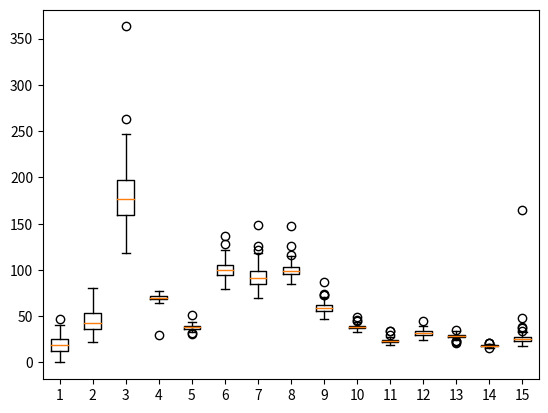

In [4]:
plt.boxplot(df_raw)

- 이상치 제거

In [29]:
df_raw.drop(df_raw[df_raw['BMI'] > 150].index, axis=0, inplace=True)
df_raw.iloc[77:80]

FAT  AGE  WEIGHT  HEIGHT  NECK  CHEST  ABDOMEN   HIP  THIGH  KNEE  ANKLE  \
77  14.1   48  176.00    73.0  36.7   96.7     86.5  98.3   60.4  39.9   24.4   
79   3.7   27  159.25    71.5  35.7   89.6     79.7  96.5   55.0  36.7   22.5   
80  18.5   61  148.25    67.5  36.0   91.6     81.8  94.8   54.5  37.0   21.4   

    BICEPS  FOREARM  WRIST        BMI  
77    28.8     29.6   18.7  23.036263  
79    29.9     28.2   17.7  21.727634  
80    29.3     27.0   18.3  22.695107

#  1)경향성 확인

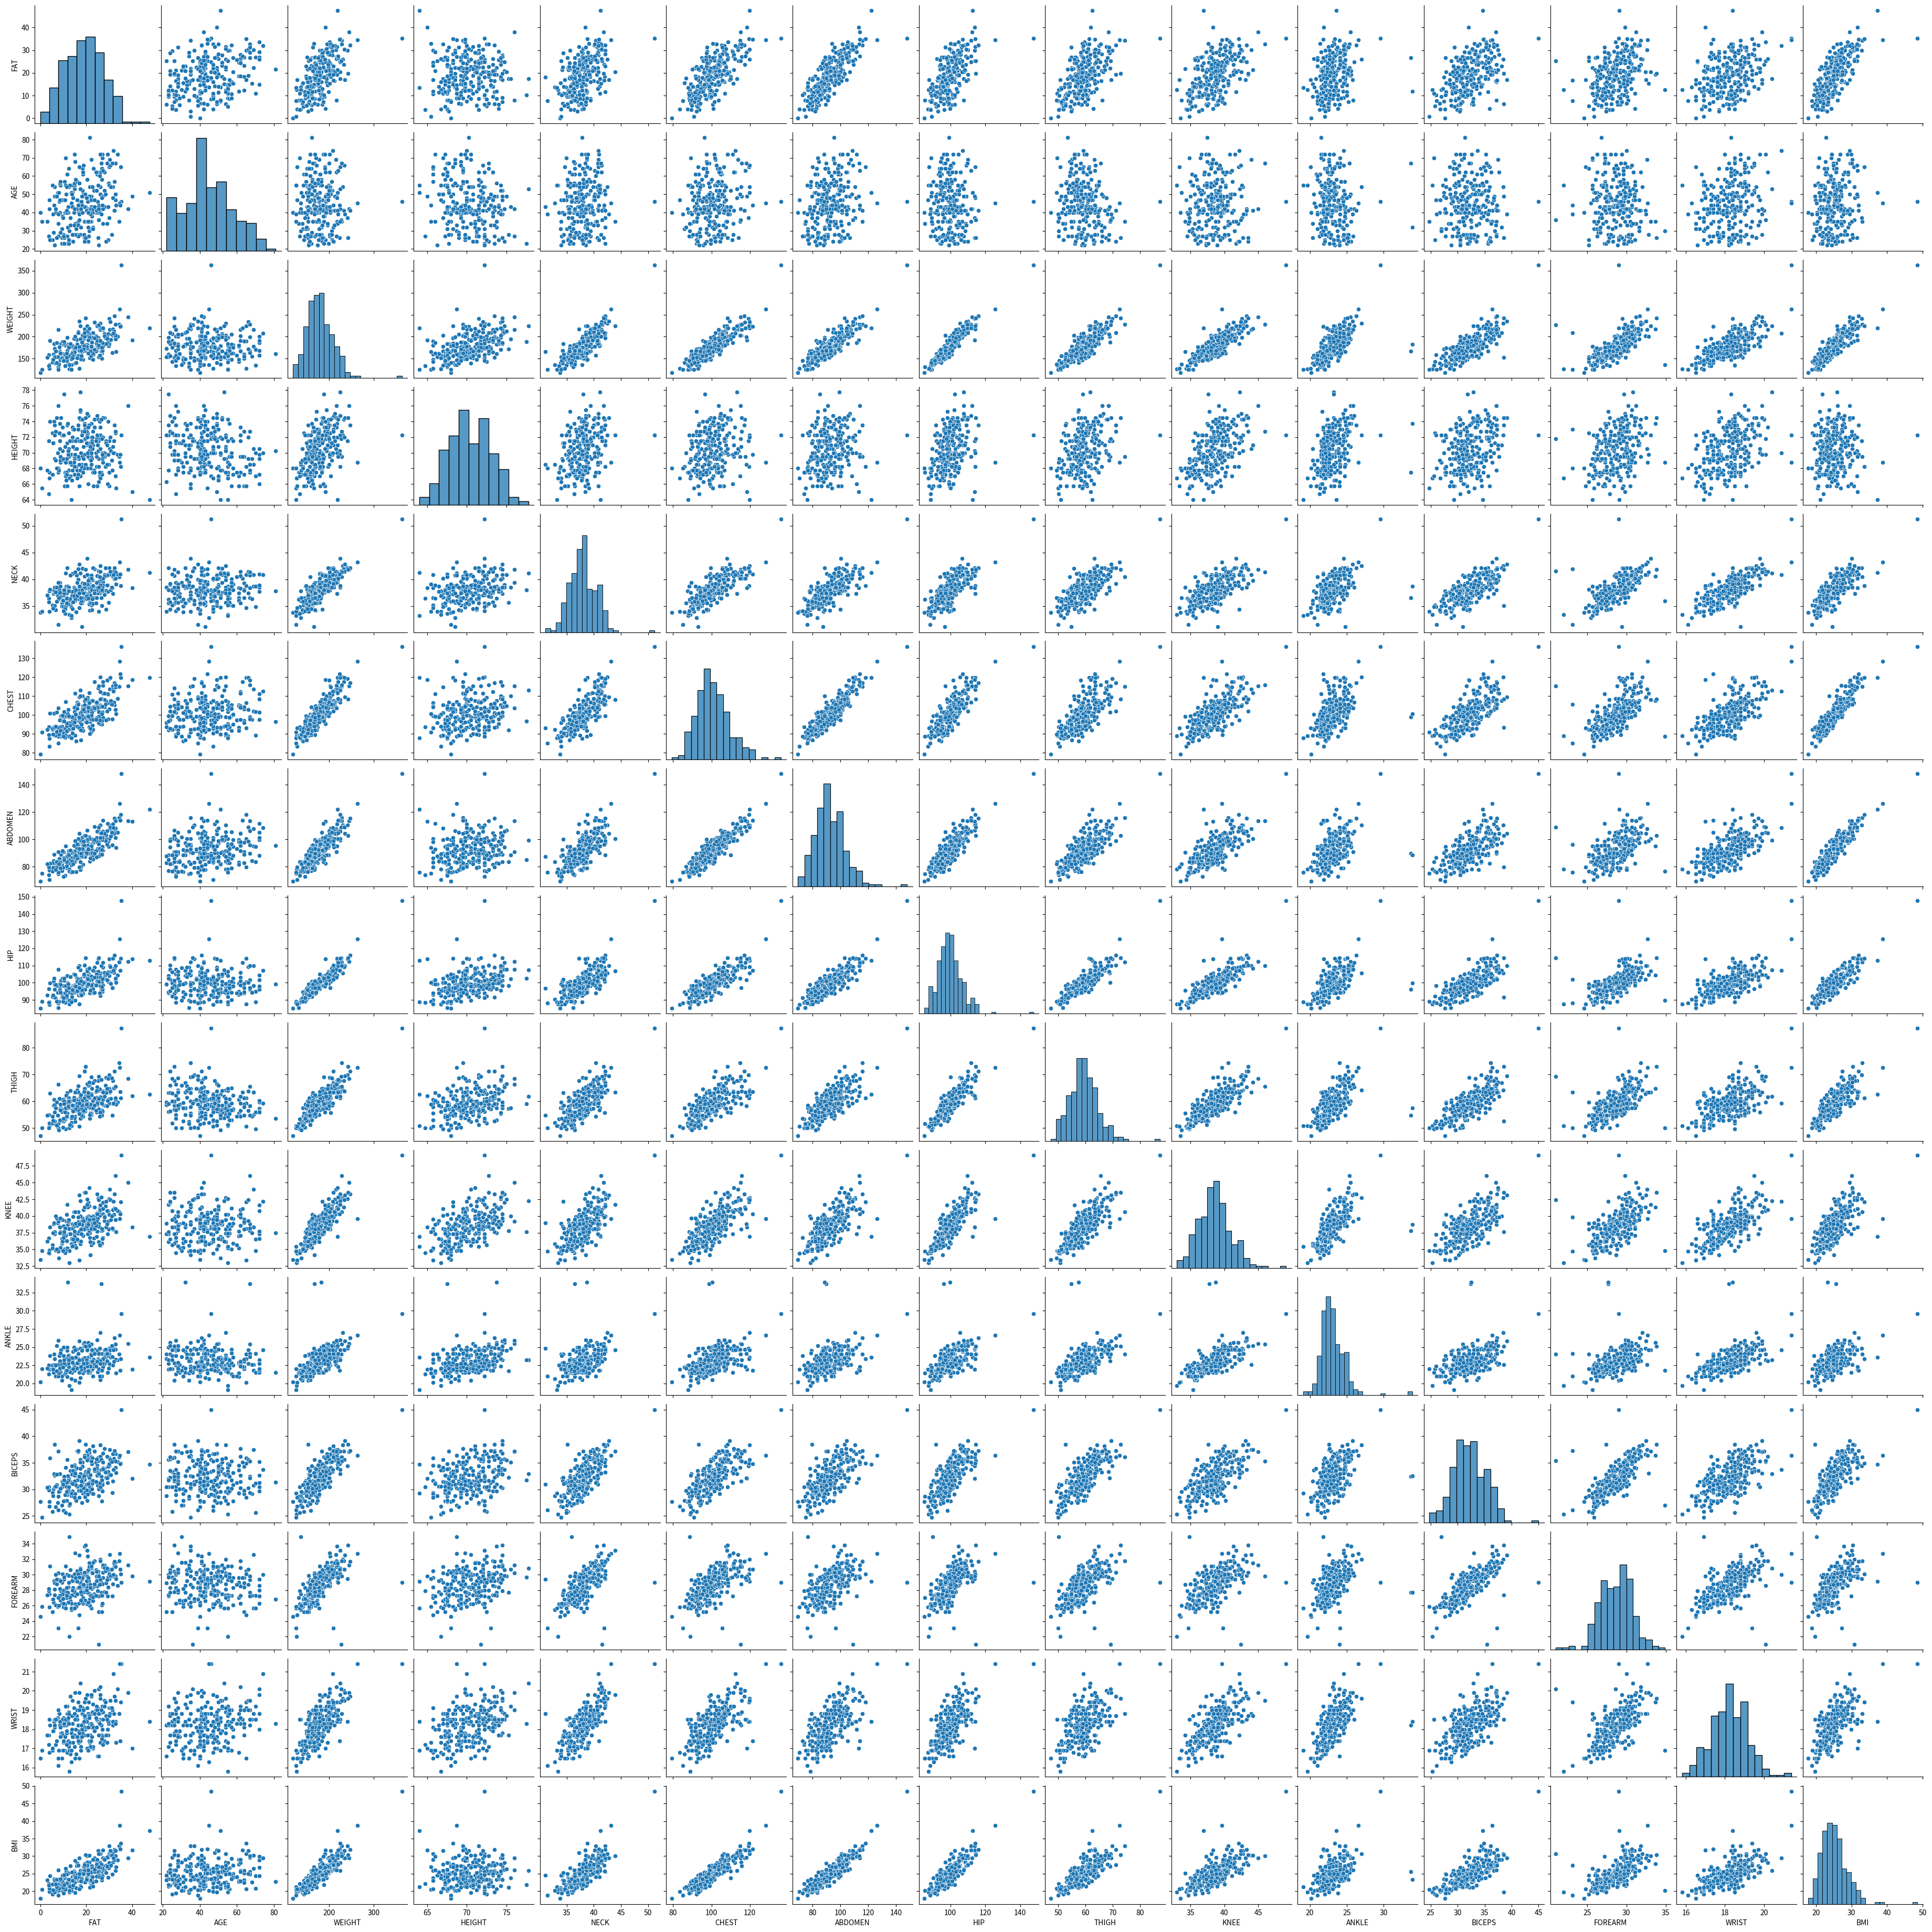

In [6]:
#산점도 행렬:전체 숫자형 변수
sns.pairplot(df_raw)

In [7]:
df_raw.corr().round(3)

FAT    AGE  WEIGHT  HEIGHT   NECK  CHEST  ABDOMEN    HIP  THIGH  \
FAT      1.000  0.294   0.611  -0.023  0.497  0.703    0.813  0.620  0.554   
AGE      0.294  1.000  -0.013  -0.245  0.113  0.177    0.231 -0.050 -0.201   
WEIGHT   0.611 -0.013   1.000   0.489  0.835  0.894    0.888  0.944  0.870   
HEIGHT  -0.023 -0.245   0.489   1.000  0.321  0.228    0.192  0.378  0.344   
NECK     0.497  0.113   0.835   0.321  1.000  0.787    0.759  0.748  0.708   
CHEST    0.703  0.177   0.894   0.228  0.787  1.000    0.916  0.833  0.732   
ABDOMEN  0.813  0.231   0.888   0.192  0.759  0.916    1.000  0.875  0.766   
HIP      0.620 -0.050   0.944   0.378  0.748  0.833    0.875  1.000  0.894   
THIGH    0.554 -0.201   0.870   0.344  0.708  0.732    0.766  0.894  1.000   
KNEE     0.503  0.018   0.853   0.505  0.680  0.720    0.736  0.821  0.797   
ANKLE    0.265 -0.105   0.614   0.394  0.479  0.483    0.453  0.561  0.542   
BICEPS   0.493 -0.041   0.800   0.319  0.733  0.728    0.685  0.743  0.765   
FOREARM  0.363 -0.085   0.631   0.322  0.624  0.581    0.504  0.550  0.572   
WRIST    0.355  0.214   0.735   0.397  0.744  0.664    0.626  0.645  0.572   
BMI      0.725  0.115   0.888   0.039  0.785  0.910    0.922  0.885  0.814   

          KNEE  ANKLE  BICEPS  FOREARM  WRIST    BMI  
FAT      0.503  0.265   0.493    0.363  0.355  0.725  
AGE      0.018 -0.105  -0.041   -0.085  0.214  0.115  
WEIGHT   0.853  0.614   0.800    0.631  0.735  0.888  
HEIGHT   0.505  0.394   0.319    0.322  0.397  0.039  
NECK     0.680  0.479   0.733    0.624  0.744  0.785  
CHEST    0.720  0.483   0.728    0.581  0.664  0.910  
ABDOMEN  0.736  0.453   0.685    0.504  0.626  0.922  
HIP      0.821  0.561   0.743    0.550  0.645  0.885  
THIGH    0.797  0.542   0.765    0.572  0.572  0.814  
KNEE     1.000  0.613   0.680    0.559  0.675  0.709  
ANKLE    0.613  1.000   0.485    0.419  0.568  0.497  
BICEPS   0.680  0.485   1.000    0.678  0.635  0.747  
FOREARM  0.559  0.419   0.678    1.000  0.587  0.561  
WRIST    0.675  0.568   0.635    0.587  1.000  0.635  
BMI      0.709  0.497   0.747    0.561  0.635  1.000

#### 체질 비만도(FAT)와 가슴 둘레(CHEST), 복부 둘레(ABDOMEN) 간의 높은 선형관계 확인
#### 설명변수 상관관계 : 다수 설명변수 간의 선형관계 확인 --> 다중공선성 확인 및 처리 필요

In [30]:
# train/test data 분리
# 데이터는 (train(0.6) : test(0.4))의 비율로 분할
df_train, df_test = train_test_split(df_raw, test_size = 0.4, random_state = 1234)
print('train data size : {}'.format(df_train.shape))
print('test data size : {}'.format(df_test.shape))

train data size : (150, 15)
test data size : (101, 15)


# 2)모델링

In [31]:
# 선형 회귀 분석: formula(y ~ X1 + X2 + ...)이용. 상수항(Intercept) 자동 추가. 코드 중간에서 줄 바꿈 "\"추가귀
reg_model = smf.ols(formula = "FAT ~ AGE + WEIGHT + HEIGHT +NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST + BMI", data = df_train)

In [32]:
#적합
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     28.28
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           2.29e-33
Time:                        22:11:05   Log-Likelihood:                -429.93
No. Observations:                 150   AIC:                             889.9
Df Residuals:                     135   BIC:                             935.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -190.6032     73.021     -2.610      0.0

### - 분석 자료수 : 150
### - 잔차 자유도 : 135
### - 모델 자유도 : 14(FAT가 빠져서)

#### - 분산분석결과 : p값이 0.05보다 작으므로 회귀모델로서 유의(모델 적합성 확인)
#### - 등분산성 p(omnibus)>0.05보다 크고, Durbin-Watson이 2에 가까우므로 등분산성, 독립성 확인 
### - 설명력 : 0.746 --> 모델을 통하여 74.6%를 설명할 수 있음
    
### - 회귀계수 검정
###    --> 절편의 유의성은 검토하지 않음.
###    --> ABDOMEN, FOREARM의 p값이 유의수준 0.05보다 작으므로 유의

In [33]:
#설명변수간의 다중공선성 확인 : 설명변수 데이터 생성 및 상수항 추가
df_train_x=df_train.drop('FAT',axis=1)
# statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)
# DataFrame으로 저장
df_vif=pd.DataFrame()
df_vif["variable"]=df_train_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_train_x_const.values,i) \
for i in range(df_train_x_const.shape[1])]

#VIF 정렬
df_vif.sort_values("VIF",ascending=True).round(2)

variable       VIF
10    ANKLE      2.20
12  FOREARM      2.59
1       AGE      2.65
13    WRIST      3.42
4      NECK      4.58
11   BICEPS      4.71
9      KNEE      4.72
8     THIGH      7.86
5     CHEST     11.17
6   ABDOMEN     15.41
7       HIP     15.81
3    HEIGHT     53.67
14      BMI    246.51
2    WEIGHT    261.54
0     const  39824.86

- WEIGHT의 VIF가 261.54로 높고 BMI(=246.51) > HEIGHT > HIP > ABDOMEN > CHEST > 10

###  WEIGHT 제거

In [34]:
#선형 회구 분석 : 모델에서 WEIGHT 제거
reg_model=smf.ols(formula="FAT ~ AGE + HEIGHT +NECK + CHEST + ABDOMEN + HIP + THIGH +\
KNEE + ANKLE + BICEPS + FOREARM + WRIST+BMI",data=df_train)

#적합
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     28.36
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           1.87e-32
Time:                        22:13:00   Log-Likelihood:                -434.28
No. Observations:                 150   AIC:                             896.6
Df Residuals:                     136   BIC:                             938.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8643     12.463      1.112      0.2

In [35]:
#다중공선성 재확인
df_train_x=df_train.drop(['FAT','WEIGHT'], axis=1)
# statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)
# DataFrame으로 저장
df_vif=pd.DataFrame()
df_vif["variable"]=df_train_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_train_x_const.values,i) \
for i in range(df_train_x_const.shape[1])]

#VIF 정렬
df_vif.sort_values("VIF",ascending=True).round(2)

variable      VIF
9     ANKLE     2.20
11  FOREARM     2.43
1       AGE     2.63
12    WRIST     3.42
3      NECK     4.41
10   BICEPS     4.49
8      KNEE     4.51
2    HEIGHT     5.51
7     THIGH     7.76
4     CHEST    10.97
5   ABDOMEN    15.33
6       HIP    15.81
13      BMI    38.99
0     const  1102.77

- BMI(=38.99) > HIP(=15.81) > ABDOMEN(=15.33) > CHEST(=10.97)

### BMI 제거

In [37]:
#다중공선성 재확인
df_train_x=df_train.drop(['FAT','WEIGHT','BMI'], axis=1)
# statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)
# DataFrame으로 저장
df_vif=pd.DataFrame()
df_vif["variable"]=df_train_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_train_x_const.values,i) \
for i in range(df_train_x_const.shape[1])]

#VIF 정렬
df_vif.sort_values("VIF",ascending=True).round(2)

variable      VIF
2    HEIGHT     1.90
9     ANKLE     1.98
11  FOREARM     2.40
1       AGE     2.52
12    WRIST     3.39
3      NECK     4.01
10   BICEPS     4.34
8      KNEE     4.51
7     THIGH     7.75
4     CHEST     8.81
6       HIP    11.19
5   ABDOMEN    12.93
0     const  1064.69

- ABDOMEN(=12.93)>HIP(11.19)>10

In [39]:
#다중공선성 재확인
df_train_x=df_train.drop(['FAT','WEIGHT','BMI','ABDOMEN'], axis=1)
# statsmodels의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)
# DataFrame으로 저장
df_vif=pd.DataFrame()
df_vif["variable"]=df_train_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_train_x_const.values,i) \
for i in range(df_train_x_const.shape[1])]

#VIF 정렬
df_vif.sort_values("VIF",ascending=True).round(2)

variable     VIF
2    HEIGHT    1.81
8     ANKLE    1.97
1       AGE    2.05
10  FOREARM    2.39
11    WRIST    3.38
3      NECK    4.00
9    BICEPS    4.31
7      KNEE    4.46
4     CHEST    5.45
6     THIGH    7.56
5       HIP    9.20
0     const  996.28

###  ABDOMEN 제거

## VIF가 10보다 큰 것이 없으므로 다중 공선성 해결 

In [42]:
reg_model = smf.ols(formula = "FAT ~ AGE + HEIGHT +NECK + CHEST + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST", data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     19.18
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           7.27e-23
Time:                        22:20:39   Log-Likelihood:                -463.03
No. Observations:                 150   AIC:                             950.1
Df Residuals:                     138   BIC:                             986.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.3173     14.244     -0.654      0.5

## 회귀계수 검정(유의수준 = 0.05)

#### 귀무가설: 회귀계수는 0이다
    
#### 대립가설: 회귀계수는 0이 아니다

In [44]:
reg_model = smf.ols(formula = " FAT ~ HEIGHT + AGE + FOREARM + BICEPS + WRIST + NECK + KNEE + CHEST + THIGH + HIP", data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     21.24
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           1.56e-23
Time:                        22:24:29   Log-Likelihood:                -463.05
No. Observations:                 150   AIC:                             948.1
Df Residuals:                     139   BIC:                             981.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.3115     14.195     -0.656      0.5

- BICEPS p값이 0.950으로 귀무가설 채택 --> BICEPS 제거

In [45]:
reg_model = smf.ols(formula =  "FAT ~ AGE + HEIGHT +NECK + CHEST + HIP + THIGH + KNEE + ANKLE + FOREARM + WRIST", data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     21.25
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           1.53e-23
Time:                        22:24:46   Log-Likelihood:                -463.03
No. Observations:                 150   AIC:                             948.1
Df Residuals:                     139   BIC:                             981.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.4056     14.128     -0.666      0.5

- ANKLE p값이 0.838로 귀무가설 채택 --> ANKLE 제거

In [47]:
reg_model = smf.ols(formula = " FAT ~ AGE + HEIGHT +NECK + CHEST + HIP + THIGH + KNEE + FOREARM + WRIST", data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     23.77
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           3.10e-24
Time:                        22:26:01   Log-Likelihood:                -463.06
No. Observations:                 150   AIC:                             946.1
Df Residuals:                     140   BIC:                             976.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.3963     14.079     -0.667      0.5

- FOREARM의 p값이 0.353으로 귀무가설 채택 --> FOREARM 제거

In [48]:
reg_model = smf.ols(formula = " FAT ~ AGE + HEIGHT +NECK + CHEST + HIP + THIGH + KNEE + WRIST", data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     26.66
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           8.77e-25
Time:                        22:27:07   Log-Likelihood:                -463.52
No. Observations:                 150   AIC:                             945.0
Df Residuals:                     141   BIC:                             972.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.6476     13.947     -0.548      0.5

- HIP의 p값이 0.322로 귀무가설 채택 --> HIP 제거

In [49]:
reg_model = smf.ols(formula = " FAT ~ AGE + HEIGHT +NECK + CHEST+ THIGH + KNEE + WRIST", data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     30.33
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           2.46e-25
Time:                        22:28:00   Log-Likelihood:                -464.04
No. Observations:                 150   AIC:                             944.1
Df Residuals:                     142   BIC:                             968.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.9574     13.929     -0.499      0.6

- KNEE의 p값이 0.195로 귀무가설 채택 --> KNEE 제거

In [50]:
reg_model = smf.ols(formula = " FAT ~ AGE + HEIGHT +NECK + CHEST+ THIGH + WRIST", data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     34.94
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           9.04e-26
Time:                        22:28:59   Log-Likelihood:                -464.93
No. Observations:                 150   AIC:                             943.9
Df Residuals:                     143   BIC:                             964.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.8898     13.779     -0.718      0.4

- WRIST의 p값이 0.071>0.05 이므로 귀무가설 채택 --> WRIST 제거

# 3) 모델의 적합성 확인

In [52]:
reg_model = smf.ols(formula = " FAT ~ AGE + HEIGHT +NECK + CHEST+ THIGH ", data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     40.61
Date:                Mon, 31 Oct 2022   Prob (F-statistic):           6.66e-26
Time:                        22:31:11   Log-Likelihood:                -466.65
No. Observations:                 150   AIC:                             945.3
Df Residuals:                     144   BIC:                             963.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.9824     13.840     -0.866      0.3

 -회귀계수의 유의성 검정 완료 -

- 회귀식의 독립변수가 종속변수를 결정계수 0.571만큼 설명하고있다.

- 즉, y=-11.9824 + 0.1685AGE - 0.5418HEIGHT -0.9548NECK + 0.6277CHEST + 0.5859THIGH

# 4)오차(잔차)의 가정 확인

## 잔차의 등분산성 검정

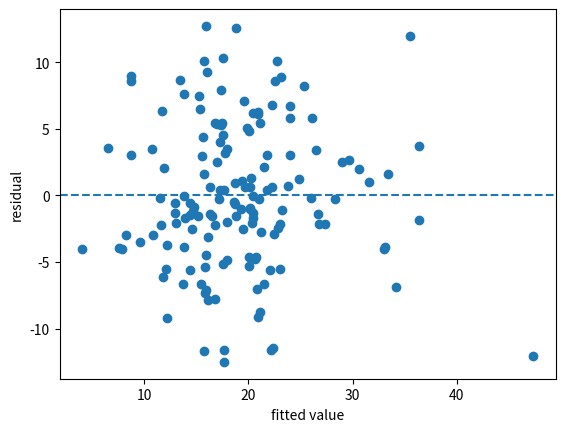

In [22]:
# 잔차 산점도 : X-예측값, Y-잔차
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0,linestyle="--")

- 잔차가 y=0을 기준으로 Random하게 산포되어 있으므로 등분산성을 만족

## 잔차의 정규성 확인

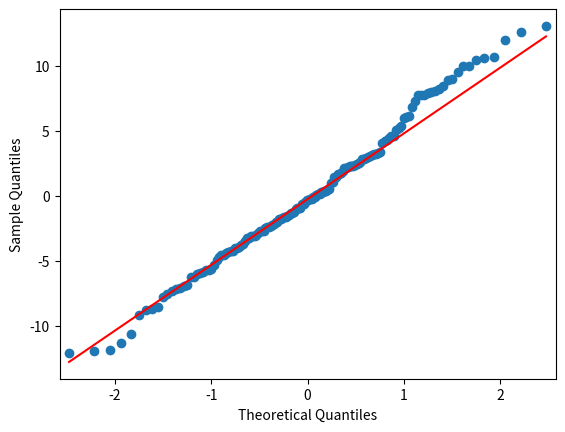

In [54]:
#잔차 정규성 검정: Q-Q plot. s-standardized line,
# r-regression line, q-quartiles
qqplot(reg_result.resid,line = "q")
plt.show()

- 정규분포 직선(적색 선)을 중심으로 분포하므로 정규분포를 따름

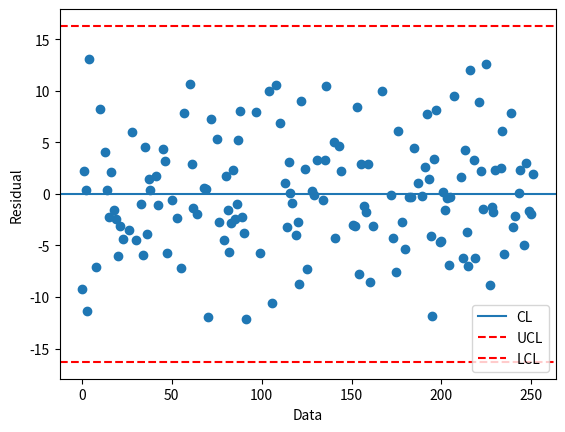

In [55]:
#잔차의 독립성 확인
plt.scatter(df_train.index, reg_result.resid)
plt.xlabel("Data") ; plt.ylabel("Residual")
plt.axhline(y=0,linestyle="-",label='CL')
plt.axhline(y=3*np.std(reg_result.resid),linestyle="--",color="red",label='UCL')
plt.axhline(y=-3*np.std(reg_result.resid), linestyle="dashed",color="red",label='LCL')
plt.legend() ; plt.show() 

- 잔차가 y=0을 기준으로 관리상하한을 벗어나지 않고, Random하게 산포되어 있으므로 독립성을 만족!

# 5)모델 확정

In [56]:
# 평가용 데이터에 대한 성능 확인
train_pred = reg_result.predict(df_train)
test_pred=reg_result.predict(df_test)
print("train data의 결정계수:", r2_score(df_train['FAT'],train_pred))
print("test data의 결정계수:", r2_score(df_test['FAT'], test_pred))

train data의 결정계수: 0.5850860182992248
test data의 결정계수: 0.5949831950117669


 회귀모델은 다소 과대 적합했다.

<AxesSubplot:>

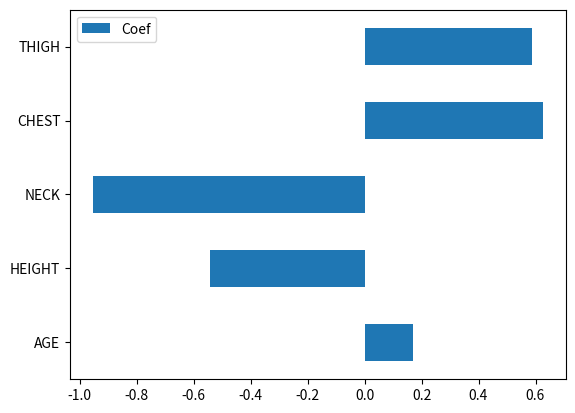

In [58]:
#설명변수 중요도
df_reg_coef=pd.DataFrame({"Coef":reg_result.params.values[1:]},
                        index=['AGE', 'HEIGHT', 'NECK', 'CHEST', 'THIGH'])
df_reg_coef.plot.barh(y="Coef")

## - NECK, HEIGHT는 작을수록, THIGH, CHEST, AGE는 클수록 FAT이 커진다.